In [173]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
import pickle
from scipy.stats import circmean

In [174]:
input_shape = (128,)
epochs = 100
batch_size = 1000

In [175]:
# layers = '3'
activation_f = 'relu'
output_f = 'tanh'
folder = 'RT_bonus'
loss_f = ''
file_name = "small_RT"
fig_size=(6, 4)


paths = []

for layers in [1, 2, 3]:
    directory = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/Model training/Models/{folder}/dense_{layers}_{loss_f}8_01_{activation_f}_{output_f}.h5"
    paths.append(directory)

loss_f = 'custom_loss_'

dirs_ed = []

for layers in [1, 2, 3]:
    directory = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/Model training/Models/{folder}/dense_{layers}_{loss_f}8_01_{activation_f}_{output_f}.h5"
    paths.append(directory)

In [176]:
def autoencoder_dense_1(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Encoder
    model.add(Dense(64, activation=activation_f))
    # Decoder
    model.add(Dense(128, activation=output_f))
    return model

def autoencoder_dense_2(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Encoder
    model.add(Dense(64, activation=activation_f))
    model.add(Dense(32, activation=activation_f))
    # Decoder
    model.add(Dense(64, activation=activation_f))
    model.add(Dense(128, activation=output_f))
    return model

def autoencoder_dense_3(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Encoder
    model.add(Dense(64, activation=activation_f))
    model.add(Dense(32, activation=activation_f))
    model.add(Dense(16, activation=activation_f))
    # Decoder
    model.add(Dense(32, activation=activation_f))
    model.add(Dense(64, activation=activation_f))
    model.add(Dense(128, activation=output_f))
    return model

In [177]:
def calculate_angles(sin_cos_conf, L):
    angles_conf = tf.atan2(sin_cos_conf[:, :L*L], sin_cos_conf[:, L*L:], )
    return angles_conf

def periodic_index(value, max_value):
    return tf.math.mod(value, max_value)


def periodic_diff(angle1, angle2):
    diff = angle1 - angle2
    diff = tf.where(diff > np.pi, diff - 2 * np.pi, diff)
    diff = tf.where(diff < -np.pi, diff + 2 * np.pi, diff)
    return diff

@tf.function
def calculate_single_lattice_energy(angles, L, J):
    # shape of the input data: number of elements in the batch, L, L
    angles = tf.reshape(angles, (L, L))

    indices = tf.range(L)
    grid_x, grid_y = tf.meshgrid(indices, indices)
    
    cell_indices = tf.stack([grid_x, grid_y], axis=-1)
    cell_indices = tf.reshape(cell_indices, (-1, 2))


    def energy_per_cell(index):
        # indices in this iteration
        i = index[0]
        j = index[1]

        neighbors = [
            angles[periodic_index(i + 1, L), j], # down
            angles[periodic_index(i - 1, L), j], # up
            angles[i, periodic_index(j + 1, L)], # right
            angles[i, periodic_index(j - 1, L)]  # left
        ]

        local_energy = tf.reduce_sum(-J * tf.math.cos(periodic_diff(angles[i, j], neighbors)))
        return local_energy


    energy_contributions = tf.vectorized_map(
            energy_per_cell,
            cell_indices
    )
    total_energy = tf.reduce_sum(energy_contributions) 

    return total_energy / 2

@tf.function
def calculate_energy(angles_batch, L, J):
    energies = tf.vectorized_map(
        lambda angles: calculate_single_lattice_energy(angles, L, J),
        angles_batch
    )
    return energies

In [178]:
@tf.function
def energy_difference(y_true, y_pred):
#     tf.config.run_functions_eagerly(False)
    L = 8
    J = 1
 
    y_true_angles = calculate_angles(y_true, L)
    y_pred_angles = calculate_angles(y_pred, L)
    
    true_energies = calculate_energy(y_true_angles, L, J)
    pred_energies = calculate_energy(y_pred_angles, L, J)
    
    energy_diff = tf.abs(true_energies - pred_energies)
    mean_energy_diff = tf.reduce_mean(energy_diff)
    
    return mean_energy_diff

In [179]:
dense_1 = autoencoder_dense_1(input_shape)
dense_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
dense_1.load_weights(paths[0])

dense_2 = autoencoder_dense_2(input_shape)
dense_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
dense_2.load_weights(paths[1])

dense_3 = autoencoder_dense_3(input_shape)
dense_3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
dense_3.load_weights(paths[2])

dense_1_ed = autoencoder_dense_1(input_shape)
dense_1_ed.compile(optimizer='adam', loss=energy_difference, metrics=['accuracy'])
dense_1_ed.load_weights(paths[3])

dense_2_ed = autoencoder_dense_2(input_shape)
dense_2_ed.compile(optimizer='adam', loss=energy_difference, metrics=['accuracy'])
dense_2_ed.load_weights(paths[4])

dense_3_ed = autoencoder_dense_3(input_shape)
dense_3_ed.compile(optimizer='adam', loss=energy_difference, metrics=['accuracy'])
dense_3_ed.load_weights(paths[5])    


In [180]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "lime", "cyan"]
names = ["dense_1", "dense_2", "dense_3", "dense_1_custom_loss", "dense_2_custom_loss", "dense_3_custom_loss"]
models = [dense_1, dense_2, dense_3, dense_1_ed, dense_2_ed, dense_3_ed]

In [181]:
def calculate_sin_cos(lattice):
#     sin_values = {}
#     cos_values = {}

    results = []

    sin_values = np.sin(lattice)
    cos_values = np.cos(lattice)
    
    result = np.concatenate((sin_values.reshape(-1, 8*8)[0], cos_values.reshape(-1, 8*8)[0]))
    results.append(result)

    return results

In [182]:
def create_neighbors_table(L):
    neighbor_table = np.empty((4, L, L), dtype=tuple)

    for i in range(L):
        for j in range(L):
            bottom_neighbor = ((i + 1) % L, j)
            top_neighbor = ((i - 1) % L, j)
            right_neighbor = (i, (j + 1) % L)
            left_neighbor = (i, (j - 1) % L)

            neighbor_table[0, i, j] = bottom_neighbor
            neighbor_table[1, i, j] = top_neighbor
            neighbor_table[2, i, j] = right_neighbor
            neighbor_table[3, i, j] = left_neighbor

    return neighbor_table

In [183]:
def calculate_lattice_energy(spins, L, J, neighbors_table):
    energy = 0.0  # Total energy
    
    for i in range(L):
        for j in range(L):
            theta = spins[i, j]
            
            bottom_neighbor = neighbors_table[0, i, j]
            top_neighbor = neighbors_table[1, i, j]
            right_neighbor = neighbors_table[2, i, j]
            left_neighbor = neighbors_table[3, i, j]

            theta_bottom = spins[bottom_neighbor]
            theta_top = spins[top_neighbor]
            theta_right = spins[right_neighbor]
            theta_left = spins[left_neighbor]

            energy -= J * (
                np.cos(theta - theta_right) +
                np.cos(theta - theta_left) +
                np.cos(theta - theta_bottom) +
                np.cos(theta - theta_top)
            )

    return energy / 2

In [184]:
def calculate_angles(sin_cos_conf, L):
    sin_cos_conf = sin_cos_conf[0]
    angles_conf = np.arctan2(sin_cos_conf[:L*L], sin_cos_conf[L*L:], )
    return angles_conf

In [186]:
def show_lattice(spins):
    plt.figure(figsize=(6, 6))
    plt.imshow(spins, cmap='twilight', interpolation='nearest')
    plt.colorbar(label='Spin Angle')
    plt.title(f'XY Spin Model at T={T}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [191]:
def init_spins(L):
    return (np.random.rand(L, L) - 0.5) * 2 * np.pi

def get_local_energy(spin, neighbors, J):
    return -J * sum(np.cos(spin - neighbor) for neighbor in neighbors)

def monte_carlo_step(spins, L, T, J):
    neighbors_table = create_neighbors_table(L)
    
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)  # Select a random spin
        
        neighbors = [
            spins[neighbors_table[0][i][j]],
            spins[neighbors_table[1][i][j]],
            spins[neighbors_table[2][i][j]],
            spins[neighbors_table[3][i][j]]
        ]

        init_energy = get_local_energy(spins[i, j], neighbors, J)
    
        d_theta = np.random.uniform(-np.pi, np.pi)
        
        new_angle = spins[i, j] + d_theta
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi

        new_energy = get_local_energy(new_angle, neighbors, J)
        
        d_energy = new_energy - init_energy
        
        if d_energy < 0 or np.random.uniform(0.0, 1.0) < np.exp(-d_energy / T):
            spins[i, j] = new_angle
        
    return spins
    
def run_simulation(L, T, n_steps, J=1, save=False, energy=False, i=0):
    spins = init_spins(L)
    neighbors_table = create_neighbors_table(L)
    energies = []
    
    spin_configs_mc = []
    spin_configs_ae_d1 = []
    spin_configs_ae_d2 = []
    spin_configs_ae_d3 = []
    spin_configs_ae_d1_ed = []
    spin_configs_ae_d2_ed = []
    spin_configs_ae_d3_ed = []
    
    spin_configs_ae_d1.append(spins.copy())
    spin_configs_ae_d2.append(spins.copy())
    spin_configs_ae_d3.append(spins.copy())
    spin_configs_ae_d1_ed.append(spins.copy())
    spin_configs_ae_d2_ed.append(spins.copy())
    spin_configs_ae_d3_ed.append(spins.copy())   
    
    energies_d1 = []
    energies_d2 = []
    energies_d3 = []
    energies_d1_ed = []
    energies_d2_ed = []
    energies_d3_ed = []

    initial_energy = calculate_lattice_energy(spins, L, J, neighbors_table)
    energies.append(initial_energy)
    
    energies_d1.append(initial_energy)
    energies_d2.append(initial_energy)
    energies_d3.append(initial_energy)
    energies_d1_ed.append(initial_energy)
    energies_d2_ed.append(initial_energy)
    energies_d3_ed.append(initial_energy)
    
    for step in range(n_steps):
        sin_cos_spins = calculate_sin_cos(spins)
        
        pred_d1 = dense_1.predict(np.array(sin_cos_spins))
        spins_d1 = calculate_angles(pred_d1, L).reshape(L, L)
        energies_d1.append(calculate_lattice_energy(spins_d1, L, J, neighbors_table))
        
        pred_d2 = dense_2.predict(np.array(sin_cos_spins))
        spins_d2 = calculate_angles(pred_d2, L).reshape(L, L)
        energies_d2.append(calculate_lattice_energy(spins_d2, L, J, neighbors_table))        
        
        pred_d3 = dense_3.predict(np.array(sin_cos_spins))
        spins_d3 = calculate_angles(pred_d3, L).reshape(L, L)
        energies_d3.append(calculate_lattice_energy(spins_d3, L, J, neighbors_table))
        
        pred_d1_ed = dense_1_ed.predict(np.array(sin_cos_spins))
        spins_d1_ed = calculate_angles(pred_d1_ed, L).reshape(L, L)
        energies_d1_ed.append(calculate_lattice_energy(spins_d1_ed, L, J, neighbors_table))
        
        pred_d2_ed = dense_2_ed.predict(np.array(sin_cos_spins))
        spins_d2_ed = calculate_angles(pred_d2_ed, L).reshape(L, L)
        energies_d2_ed.append(calculate_lattice_energy(spins_d2_ed, L, J, neighbors_table))        
        
        pred_d3_ed = dense_3_ed.predict(np.array(sin_cos_spins))
        spins_d3_ed = calculate_angles(pred_d3_ed, L).reshape(L, L)
        energies_d3_ed.append(calculate_lattice_energy(spins_d3_ed, L, J, neighbors_table))
        
        spins = monte_carlo_step(spins, L, T, J)
        
        if energy:
            energy = calculate_lattice_energy(spins, L, J, neighbors_table)
            energies.append(energy)
        
        if save:
            path_name = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/{i}/{L}/{T}/{step}.txt"
            os.makedirs(os.path.dirname(path_name), exist_ok=True)
            np.savetxt(path_name, spins)
            
        if step % 10 == 0:
            spin_configs_mc.append(spins.copy())
            spin_configs_ae_d1.append(spins_d1.copy())
            spin_configs_ae_d2.append(spins_d2.copy())
            spin_configs_ae_d3.append(spins_d3.copy())
            spin_configs_ae_d1_ed.append(spins_d1_ed.copy())
            spin_configs_ae_d2_ed.append(spins_d2_ed.copy())
            spin_configs_ae_d3_ed.append(spins_d3_ed.copy())   
    
    autoencoder_energies = [energies_d1, energies_d2, energies_d3, energies_d1_ed, energies_d2_ed, energies_d3_ed]
    names = ["dense_1", "dense_2", "dense_3", "dense_1_custom_loss", "dense_2_custom_loss", "dense_3_custom_loss"]
    colors = ["cyan", "dodgerblue", "blue", "greenyellow", "forestgreen", "darkslategrey"]
    
    plt.figure(figsize=fig_size)
    plt.plot(energies, label="Monte Carlo simulation", linewidth=2, linestyle="--", color="red")
    for i, energy in enumerate(autoencoder_energies):
        plt.plot(energy, label=f"{names[i]} prediction", color=colors[i])
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Energy")    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{file_name}_all.png")
    plt.show()
    
    for idx in range(len(spin_configs_mc)):
        plt.figure(figsize=(18, 9))
        
        plt.subplot(1, 7, 1)
        plt.imshow(spin_configs_mc[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'MC step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 2)
        plt.imshow(spin_configs_ae_d1[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 3)
        plt.imshow(spin_configs_ae_d2[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 4)
        plt.imshow(spin_configs_ae_d3[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 5)
        plt.imshow(spin_configs_ae_d1_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 6)
        plt.imshow(spin_configs_ae_d2_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 7)
        plt.imshow(spin_configs_ae_d3_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')        
        
        plt.tight_layout()
        plt.show()  
        
    return spins

def show_lattice(spins):
    plt.figure(figsize=(6, 6))
    plt.imshow(spins, cmap='twilight', interpolation='nearest')
    plt.colorbar(label='Spin Angle')
    plt.title(f'XY Spin Model at T={T}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━

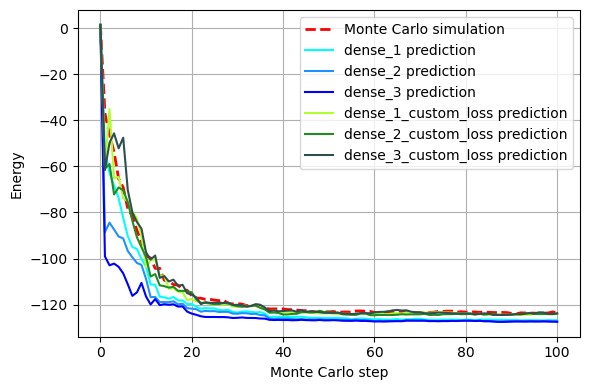

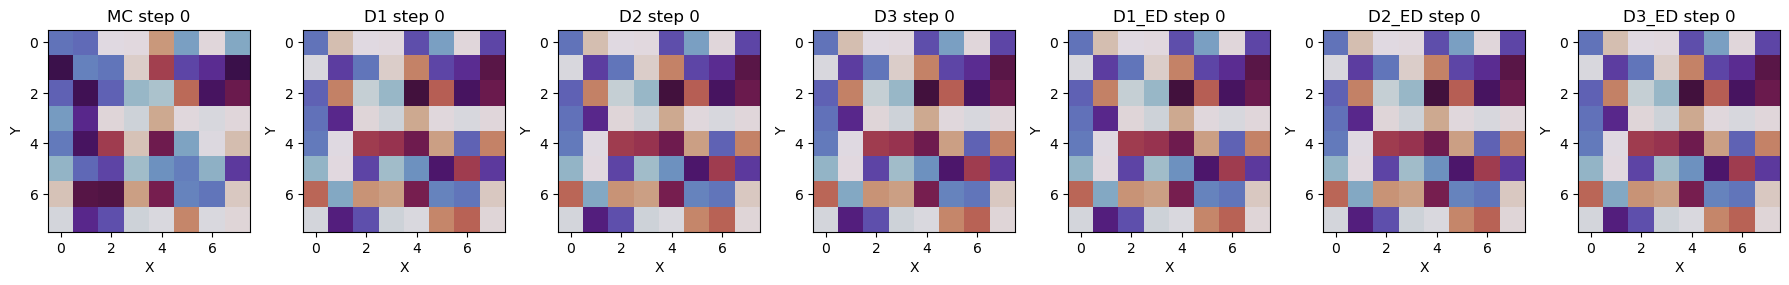

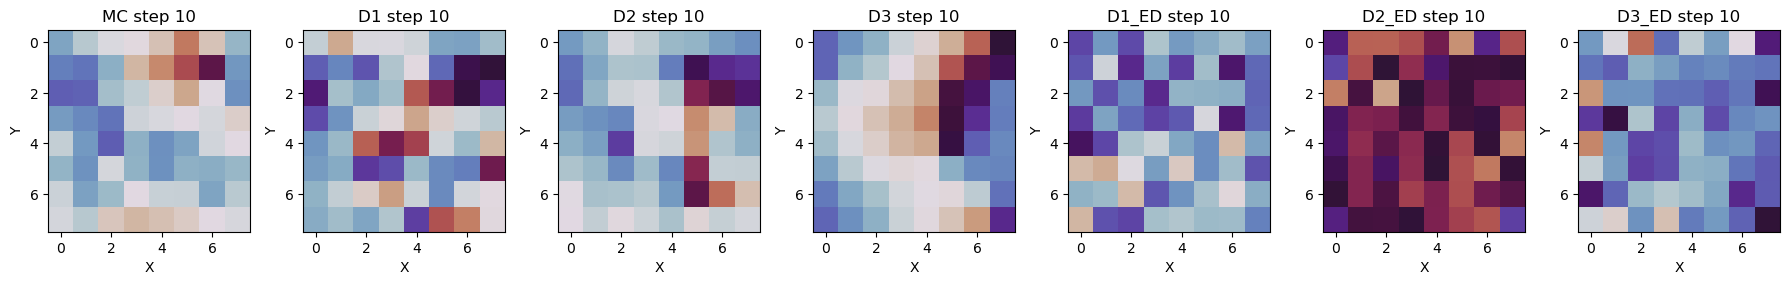

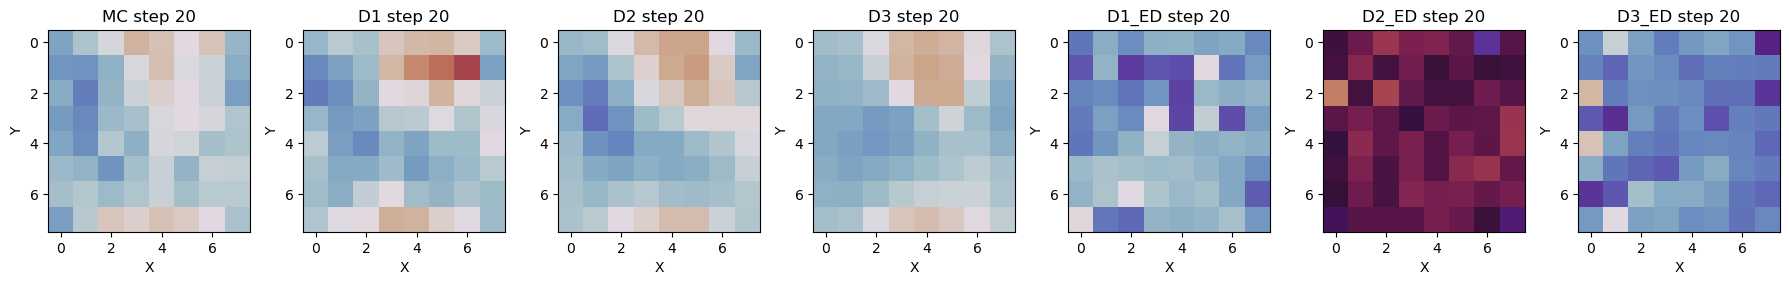

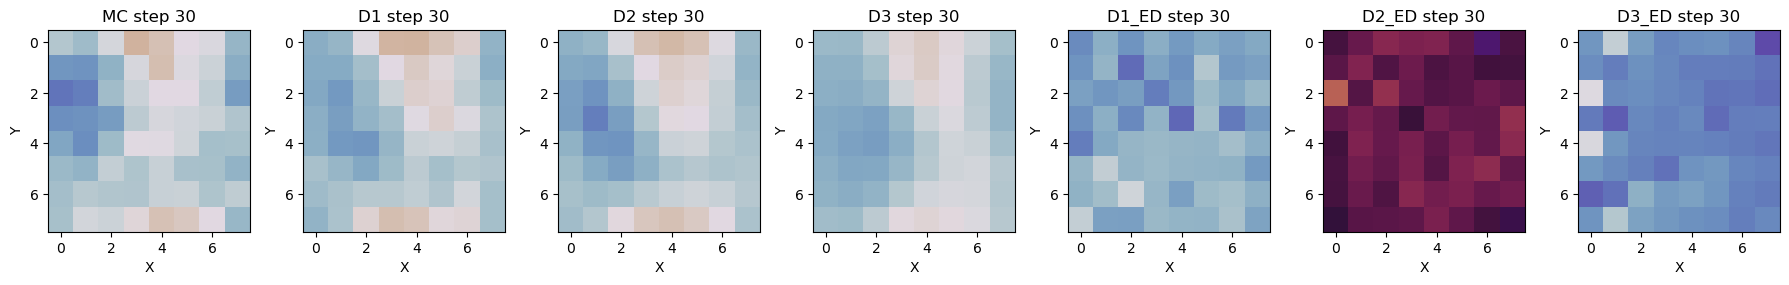

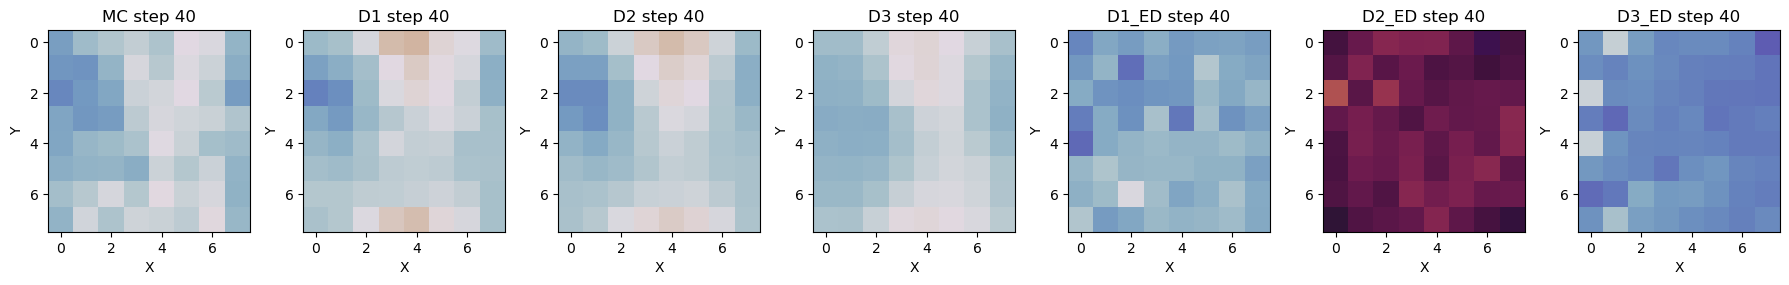

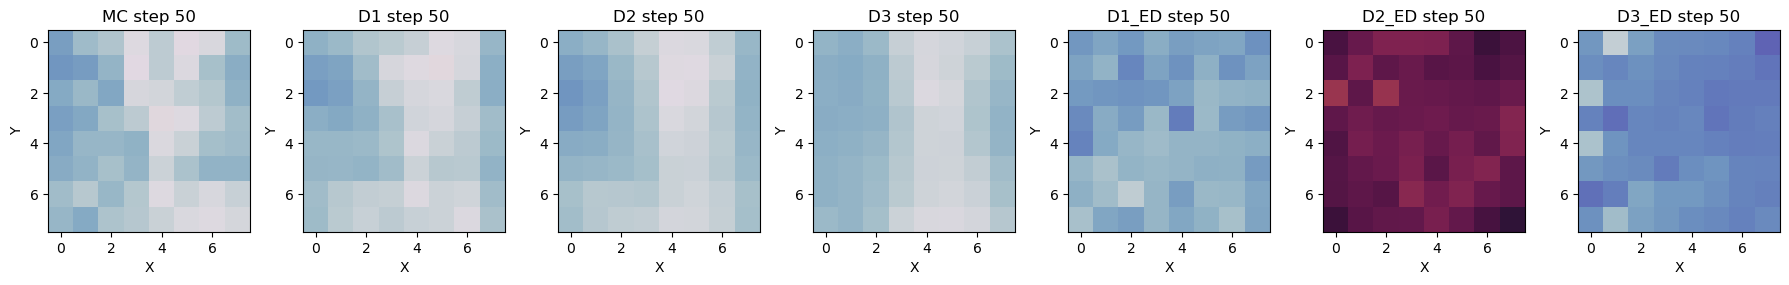

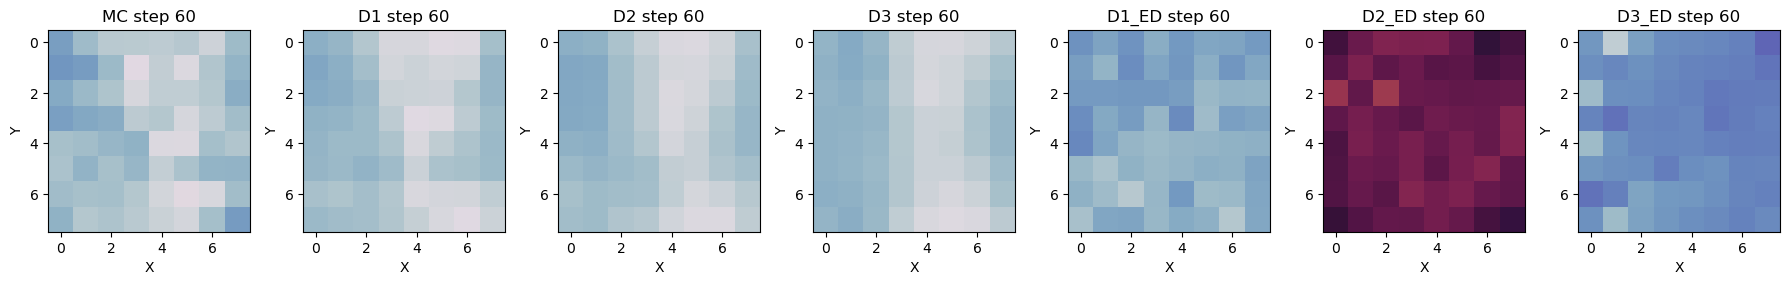

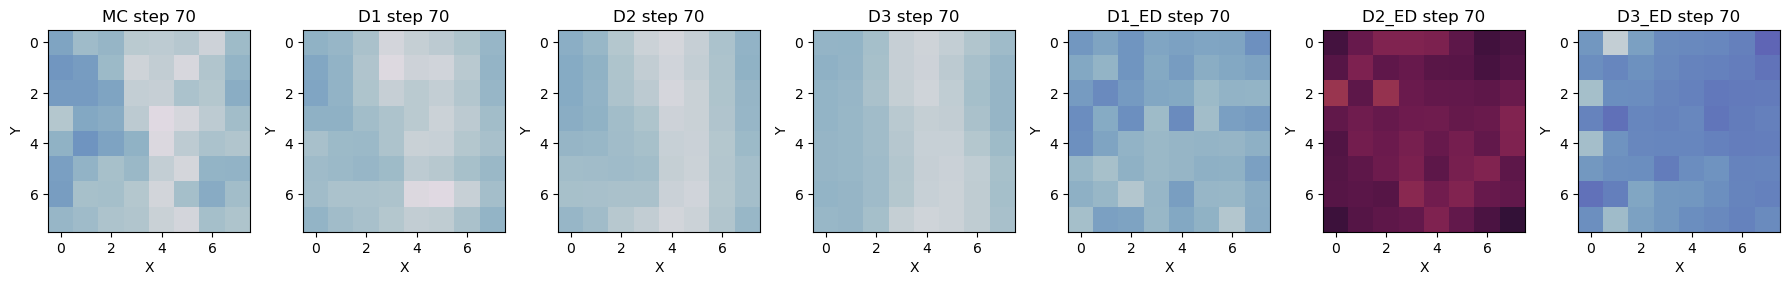

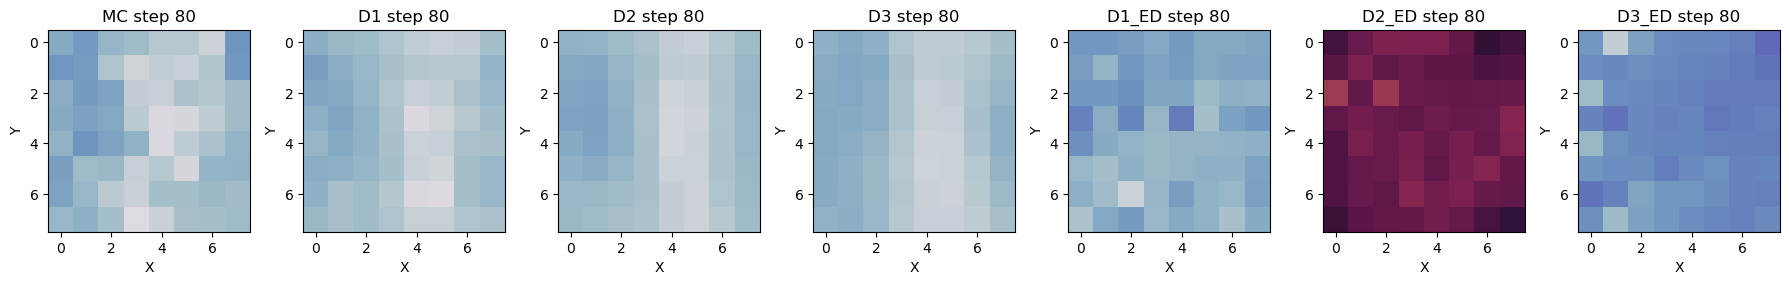

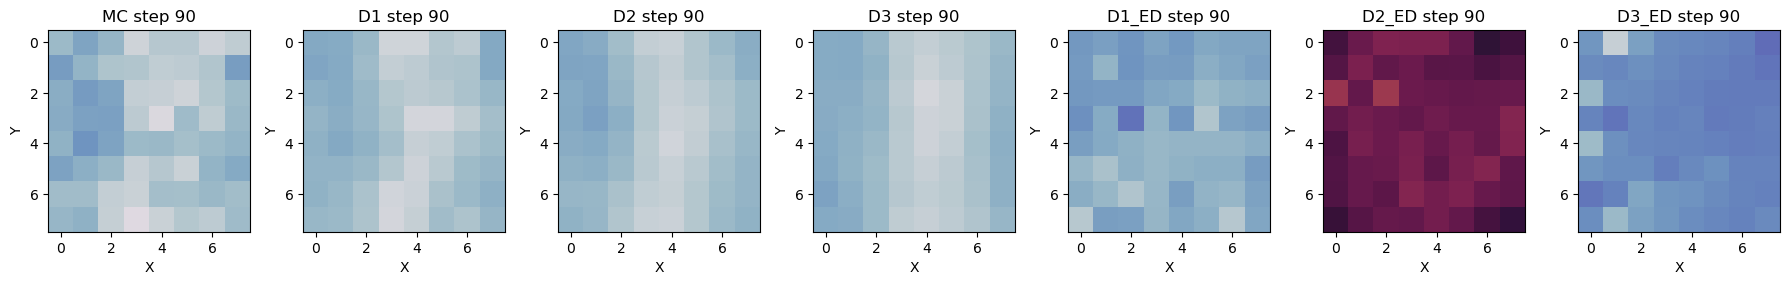

In [192]:
L = 8
J = 1.0
T = 0.1
n_steps = 100

result = run_simulation(L, T, n_steps, energy=True)

In [193]:
def init_spins(L):
    return (np.random.rand(L, L) - 0.5) * 2 * np.pi

def get_local_energy(spin, neighbors, J):
    return -J * sum(np.cos(spin - neighbor) for neighbor in neighbors)

def monte_carlo_step(spins, L, T, J):
    neighbors_table = create_neighbors_table(L)
    
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)  # Select a random spin
        
        neighbors = [
            spins[neighbors_table[0][i][j]],
            spins[neighbors_table[1][i][j]],
            spins[neighbors_table[2][i][j]],
            spins[neighbors_table[3][i][j]]
        ]

        init_energy = get_local_energy(spins[i, j], neighbors, J)
    
        d_theta = np.random.uniform(-np.pi, np.pi)
        
        new_angle = spins[i, j] + d_theta
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi

        new_energy = get_local_energy(new_angle, neighbors, J)
        
        d_energy = new_energy - init_energy
        
        if d_energy < 0 or np.random.uniform(0.0, 1.0) < np.exp(-d_energy / T):
            spins[i, j] = new_angle
        
    return spins
    
def run_simulation_sep(L, T, n_steps, J=1, save=False, energy=False, i=0):
    spins = init_spins(L)
    neighbors_table = create_neighbors_table(L)
    energies = []
    
    spin_configs_mc = []
    spin_configs_ae_d1 = []
    spin_configs_ae_d2 = []
    spin_configs_ae_d3 = []
    spin_configs_ae_d1_ed = []
    spin_configs_ae_d2_ed = []
    spin_configs_ae_d3_ed = []
    
    spin_configs_ae_d1.append(spins.copy())
    spin_configs_ae_d2.append(spins.copy())
    spin_configs_ae_d3.append(spins.copy())
    spin_configs_ae_d1_ed.append(spins.copy())
    spin_configs_ae_d2_ed.append(spins.copy())
    spin_configs_ae_d3_ed.append(spins.copy())   
    
    energies_d1 = []
    energies_d2 = []
    energies_d3 = []
    energies_d1_ed = []
    energies_d2_ed = []
    energies_d3_ed = []
    
    spins_d1 = spins
    spins_d2 = spins
    spins_d3 = spins
    spins_d1_ed = spins
    spins_d2_ed = spins
    spins_d3_ed = spins    

    initial_energy = calculate_lattice_energy(spins, L, J, neighbors_table)
    energies.append(initial_energy)
    
    energies_d1.append(initial_energy)
    energies_d2.append(initial_energy)
    energies_d3.append(initial_energy)
    energies_d1_ed.append(initial_energy)
    energies_d2_ed.append(initial_energy)
    energies_d3_ed.append(initial_energy)
    
    for step in range(n_steps):
        
        pred_d1 = dense_1.predict(np.array(calculate_sin_cos(spins_d1)))
        spins_d1 = calculate_angles(pred_d1, L).reshape(L, L)
        energies_d1.append(calculate_lattice_energy(spins_d1, L, J, neighbors_table))
        
        pred_d2 = dense_2.predict(np.array(calculate_sin_cos(spins_d2)))
        spins_d2 = calculate_angles(pred_d2, L).reshape(L, L)
        energies_d2.append(calculate_lattice_energy(spins_d2, L, J, neighbors_table))        
        
        pred_d3 = dense_3.predict(np.array(calculate_sin_cos(spins_d3)))
        spins_d3 = calculate_angles(pred_d3, L).reshape(L, L)
        energies_d3.append(calculate_lattice_energy(spins_d3, L, J, neighbors_table))
        
        pred_d1_ed = dense_1_ed.predict(np.array(calculate_sin_cos(spins_d1_ed)))
        spins_d1_ed = calculate_angles(pred_d1_ed, L).reshape(L, L)
        energies_d1_ed.append(calculate_lattice_energy(spins_d1_ed, L, J, neighbors_table))
        
        pred_d2_ed = dense_2_ed.predict(np.array(calculate_sin_cos(spins_d2_ed)))
        spins_d2_ed = calculate_angles(pred_d2_ed, L).reshape(L, L)
        energies_d2_ed.append(calculate_lattice_energy(spins_d2_ed, L, J, neighbors_table))        
        
        pred_d3_ed = dense_3_ed.predict(np.array(calculate_sin_cos(spins_d3_ed)))
        spins_d3_ed = calculate_angles(pred_d3_ed, L).reshape(L, L)
        energies_d3_ed.append(calculate_lattice_energy(spins_d3_ed, L, J, neighbors_table))
        
        spins = monte_carlo_step(spins, L, T, J)
        
        if energy:
            energy = calculate_lattice_energy(spins, L, J, neighbors_table)
            energies.append(energy)
        
        if save:
            path_name = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/{i}/{L}/{T}/{step}.txt"
            os.makedirs(os.path.dirname(path_name), exist_ok=True)
            np.savetxt(path_name, spins)
            
        if step % 10 == 0:
            spin_configs_mc.append(spins.copy())
            spin_configs_ae_d1.append(spins_d1.copy())
            spin_configs_ae_d2.append(spins_d2.copy())
            spin_configs_ae_d3.append(spins_d3.copy())
            spin_configs_ae_d1_ed.append(spins_d1_ed.copy())
            spin_configs_ae_d2_ed.append(spins_d2_ed.copy())
            spin_configs_ae_d3_ed.append(spins_d3_ed.copy())   
    
    autoencoder_energies = [energies_d1, energies_d2, energies_d3, energies_d1_ed, energies_d2_ed, energies_d3_ed]
    names = ["dense_1", "dense_2", "dense_3", "dense_1_custom_loss", "dense_2_custom_loss", "dense_3_custom_loss"]
    colors = ["cyan", "dodgerblue", "blue", "greenyellow", "forestgreen", "darkslategrey"]
    
    plt.figure(figsize=fig_size)
    plt.plot(energies, label="Monte Carlo simulation", linewidth=2, linestyle="--", color="red")
    for i, energy in enumerate(autoencoder_energies):
        plt.plot(energy, label=f"{names[i]} prediction", color=colors[i])
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Energy")    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{file_name}_all_sep.png")
    plt.show()
    
    for idx in range(len(spin_configs_mc)):
        plt.figure(figsize=(18, 9))
        
        plt.subplot(1, 7, 1)
        plt.imshow(spin_configs_mc[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'MC step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 2)
        plt.imshow(spin_configs_ae_d1[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 3)
        plt.imshow(spin_configs_ae_d2[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 4)
        plt.imshow(spin_configs_ae_d3[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 5)
        plt.imshow(spin_configs_ae_d1_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 6)
        plt.imshow(spin_configs_ae_d2_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        plt.subplot(1, 7, 7)
        plt.imshow(spin_configs_ae_d3_ed[idx], cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')        
        
        plt.tight_layout()
        plt.show()  
        
    return spins

def show_lattice(spins):
    plt.figure(figsize=(6, 6))
    plt.imshow(spins, cmap='twilight', interpolation='nearest')
    plt.colorbar(label='Spin Angle')
    plt.title(f'XY Spin Model at T={T}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

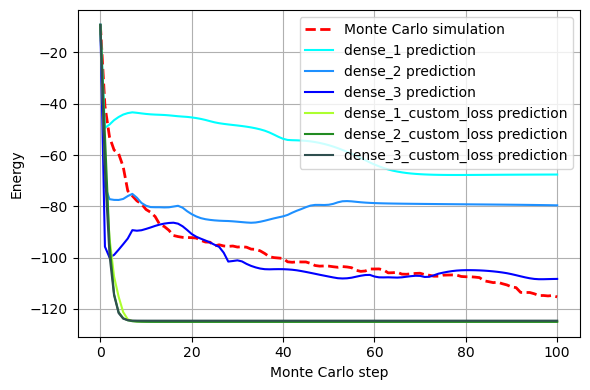

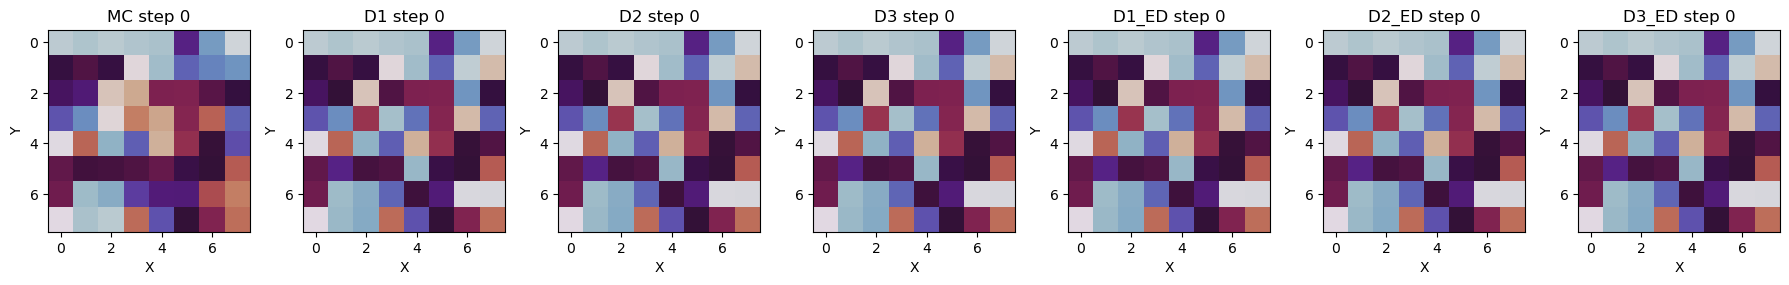

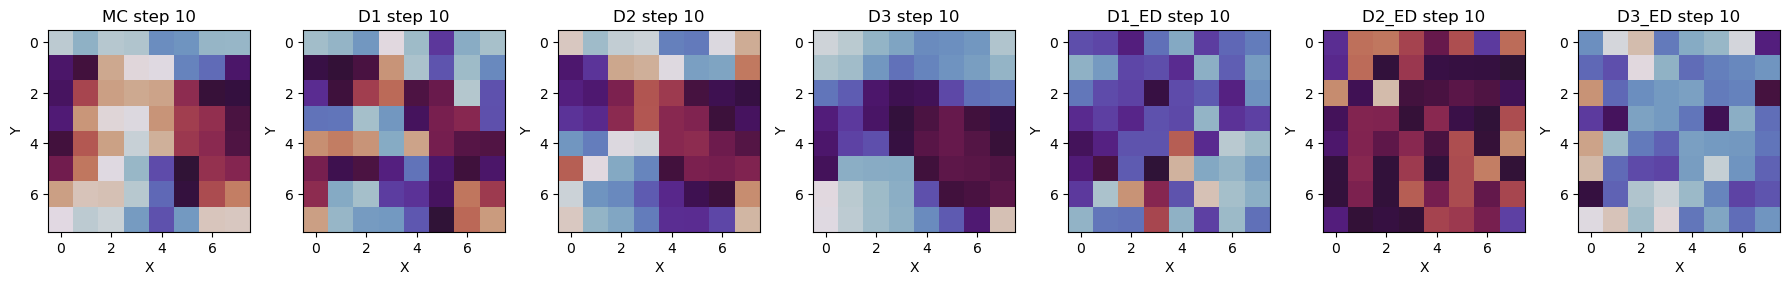

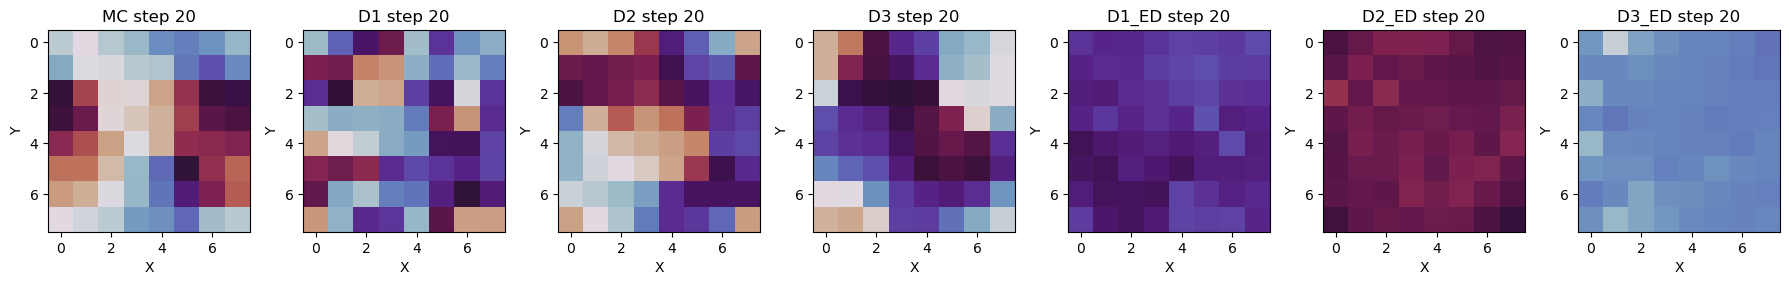

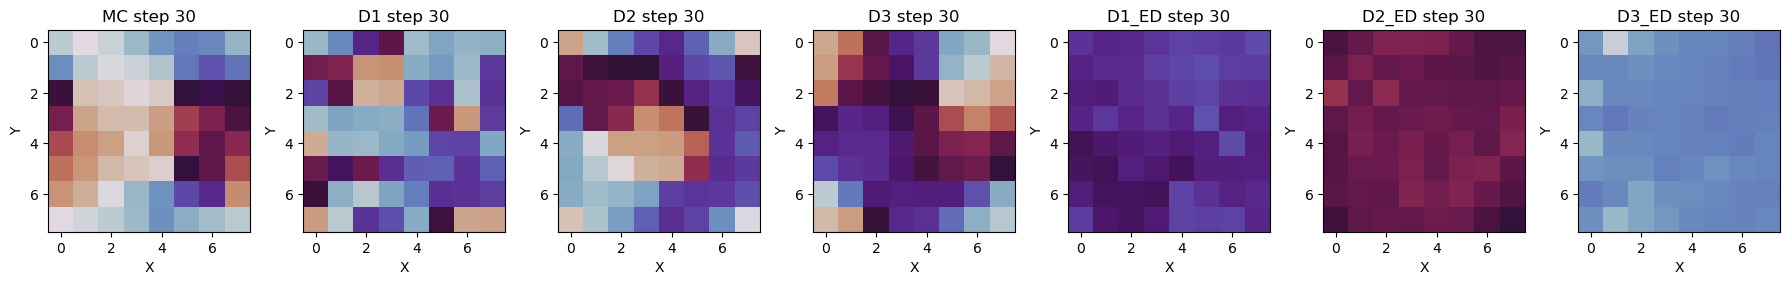

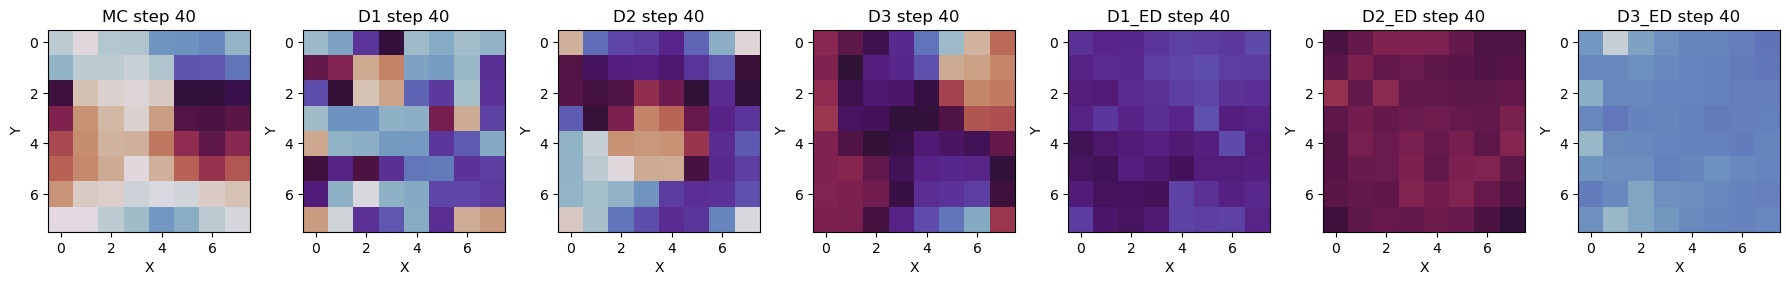

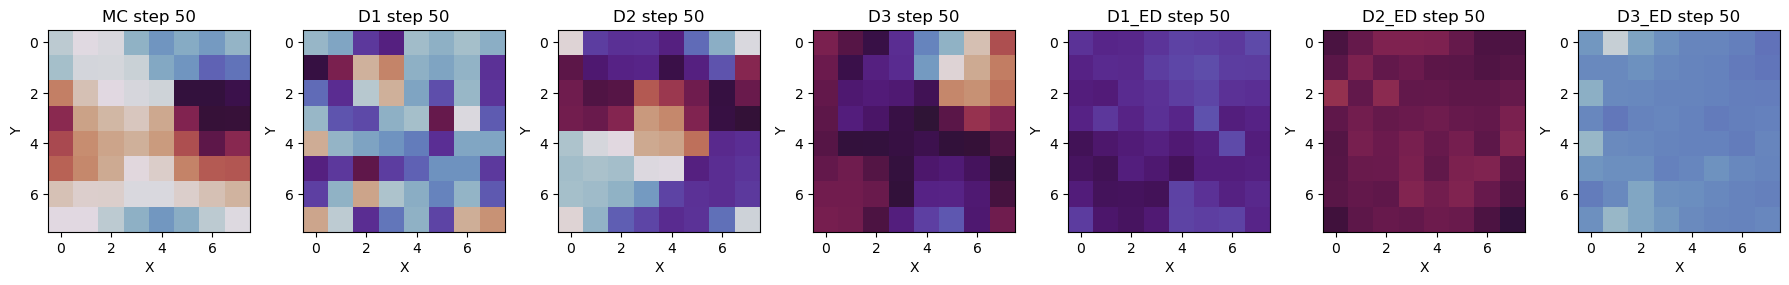

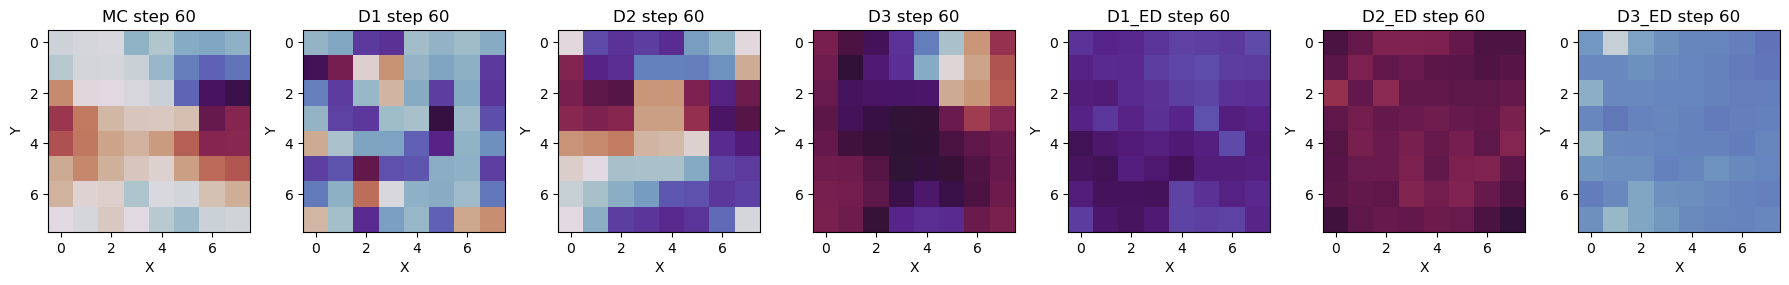

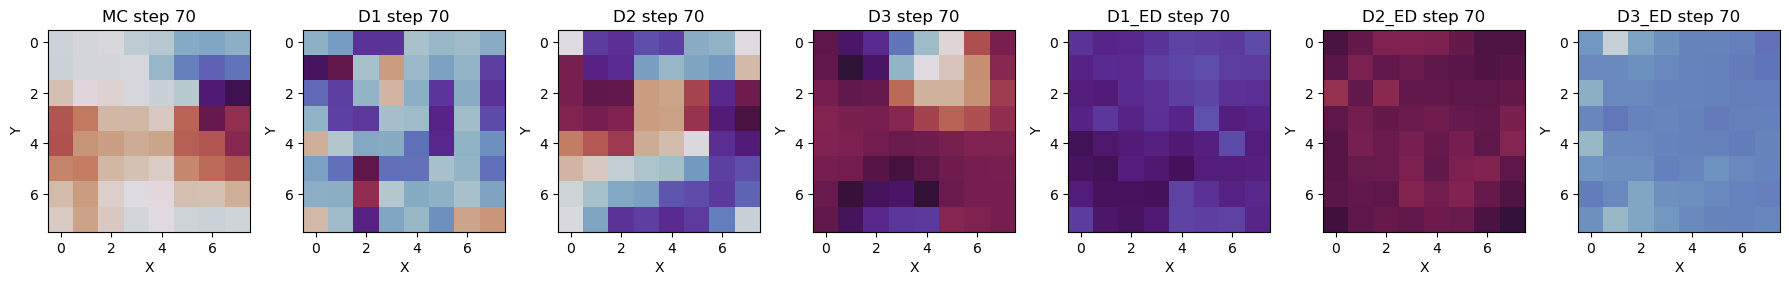

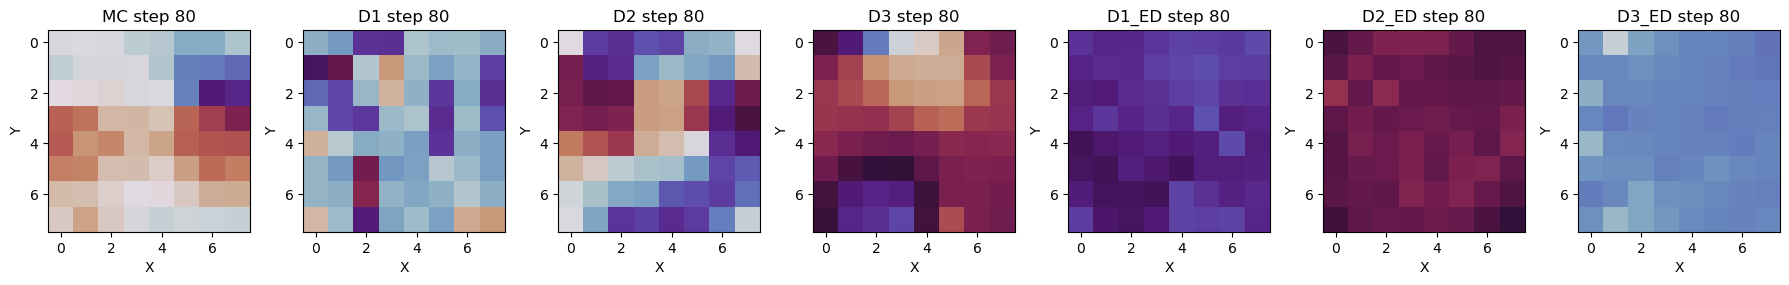

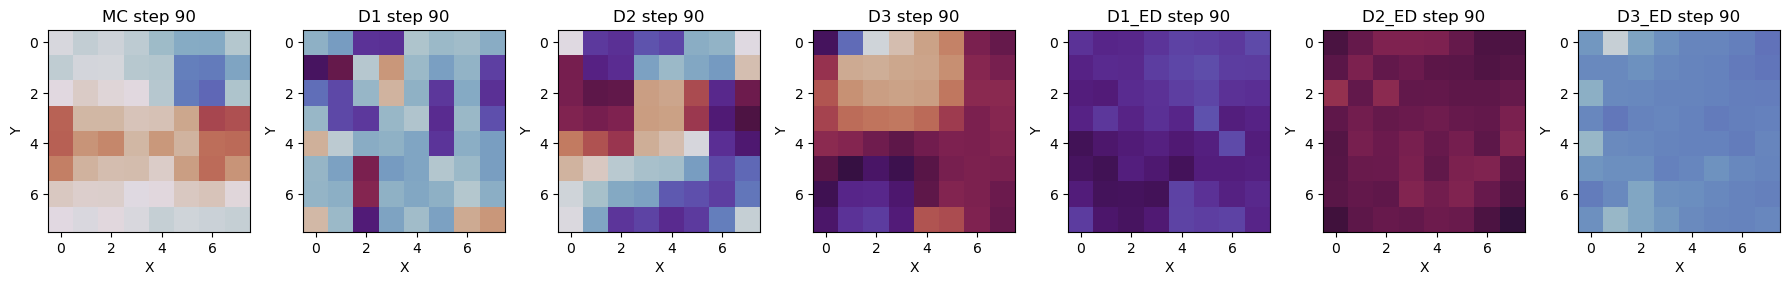

In [194]:
L = 8
J = 1.0
T = 0.1
n_steps = 100

result = run_simulation_sep(L, T, n_steps, energy=True)

In [195]:
def init_spins(L):
    return (np.random.rand(L, L) - 0.5) * 2 * np.pi

def get_local_energy(spin, neighbors, J):
    return -J * sum(np.cos(spin - neighbor) for neighbor in neighbors)

def monte_carlo_step(spins, L, T, J):
    neighbors_table = create_neighbors_table(L)
    
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)  # Select a random spin
        
        neighbors = [
            spins[neighbors_table[0][i][j]],
            spins[neighbors_table[1][i][j]],
            spins[neighbors_table[2][i][j]],
            spins[neighbors_table[3][i][j]]
        ]

        init_energy = get_local_energy(spins[i, j], neighbors, J)
    
        d_theta = np.random.uniform(-np.pi, np.pi)
        
        new_angle = spins[i, j] + d_theta
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi

        new_energy = get_local_energy(new_angle, neighbors, J)
        
        d_energy = new_energy - init_energy
        
        if d_energy < 0 or np.random.uniform(0.0, 1.0) < np.exp(-d_energy / T):
            spins[i, j] = new_angle
        
    return spins
    
def run_simulation_norm_circmean(L, T, n_steps, J=1, save=False, energy=False, i=0):
    spins = init_spins(L)
    neighbors_table = create_neighbors_table(L)
    energies = []
    
    spin_configs_mc = []
    spin_configs_ae_d1 = []
    spin_configs_ae_d2 = []
    spin_configs_ae_d3 = []
    spin_configs_ae_d1_ed = []
    spin_configs_ae_d2_ed = []
    spin_configs_ae_d3_ed = []
    
    spin_configs_ae_d1.append(spins.copy())
    spin_configs_ae_d2.append(spins.copy())
    spin_configs_ae_d3.append(spins.copy())
    spin_configs_ae_d1_ed.append(spins.copy())
    spin_configs_ae_d2_ed.append(spins.copy())
    spin_configs_ae_d3_ed.append(spins.copy())   
    
    energies_d1 = []
    energies_d2 = []
    energies_d3 = []
    energies_d1_ed = []
    energies_d2_ed = []
    energies_d3_ed = []

    initial_energy = calculate_lattice_energy(spins, L, J, neighbors_table)
    energies.append(initial_energy)
    
    energies_d1.append(initial_energy)
    energies_d2.append(initial_energy)
    energies_d3.append(initial_energy)
    energies_d1_ed.append(initial_energy)
    energies_d2_ed.append(initial_energy)
    energies_d3_ed.append(initial_energy)
    
    for step in range(n_steps):
        sin_cos_spins = calculate_sin_cos(spins)
        
        pred_d1 = dense_1.predict(np.array(sin_cos_spins))
        spins_d1 = calculate_angles(pred_d1, L).reshape(L, L)
        energies_d1.append(calculate_lattice_energy(spins_d1, L, J, neighbors_table))
        
        pred_d2 = dense_2.predict(np.array(sin_cos_spins))
        spins_d2 = calculate_angles(pred_d2, L).reshape(L, L)
        energies_d2.append(calculate_lattice_energy(spins_d2, L, J, neighbors_table))        
        
        pred_d3 = dense_3.predict(np.array(sin_cos_spins))
        spins_d3 = calculate_angles(pred_d3, L).reshape(L, L)
        energies_d3.append(calculate_lattice_energy(spins_d3, L, J, neighbors_table))
        
        pred_d1_ed = dense_1_ed.predict(np.array(sin_cos_spins))
        spins_d1_ed = calculate_angles(pred_d1_ed, L).reshape(L, L)
        energies_d1_ed.append(calculate_lattice_energy(spins_d1_ed, L, J, neighbors_table))
        
        pred_d2_ed = dense_2_ed.predict(np.array(sin_cos_spins))
        spins_d2_ed = calculate_angles(pred_d2_ed, L).reshape(L, L)
        energies_d2_ed.append(calculate_lattice_energy(spins_d2_ed, L, J, neighbors_table))        
        
        pred_d3_ed = dense_3_ed.predict(np.array(sin_cos_spins))
        spins_d3_ed = calculate_angles(pred_d3_ed, L).reshape(L, L)
        energies_d3_ed.append(calculate_lattice_energy(spins_d3_ed, L, J, neighbors_table))
        
        spins = monte_carlo_step(spins, L, T, J)
        
        if energy:
            energy = calculate_lattice_energy(spins, L, J, neighbors_table)
            energies.append(energy)
        
        if save:
            path_name = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/{i}/{L}/{T}/{step}.txt"
            os.makedirs(os.path.dirname(path_name), exist_ok=True)
            np.savetxt(path_name, spins)
            
        if step % 10 == 0:
            spin_configs_mc.append(spins.copy())
            spin_configs_ae_d1.append(spins_d1.copy())
            spin_configs_ae_d2.append(spins_d2.copy())
            spin_configs_ae_d3.append(spins_d3.copy())
            spin_configs_ae_d1_ed.append(spins_d1_ed.copy())
            spin_configs_ae_d2_ed.append(spins_d2_ed.copy())
            spin_configs_ae_d3_ed.append(spins_d3_ed.copy())   
    
    autoencoder_energies = [energies_d1, energies_d2, energies_d3, energies_d1_ed, energies_d2_ed, energies_d3_ed]
    names = ["dense_1", "dense_2", "dense_3", "dense_1_custom_loss", "dense_2_custom_loss", "dense_3_custom_loss"]
    colors = ["cyan", "dodgerblue", "blue", "greenyellow", "forestgreen", "darkslategrey"]
    
    plt.figure(figsize=fig_size)
    plt.plot(energies, label="Monte Carlo simulation", linewidth=2, linestyle="--", color="red")
    for i, energy in enumerate(autoencoder_energies):
        plt.plot(energy, label=f"{names[i]} prediction", color=colors[i])
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Energy")    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{file_name}_all_circnorm.png")
    plt.show()
    
    for idx in range(len(spin_configs_mc)):
        plt.figure(figsize=(18, 9))
        
        mc = (spin_configs_mc[idx] - circmean(spin_configs_mc[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 1)
        plt.imshow(mc, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'MC step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d1 = (spin_configs_ae_d1[idx] - circmean(spin_configs_ae_d1[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 2)
        plt.imshow(d1, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')

        d2 = (spin_configs_ae_d2[idx] - circmean(spin_configs_ae_d2[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 3)
        plt.imshow(d2, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')

        d3 = (spin_configs_ae_d3[idx] - circmean(spin_configs_ae_d3[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 4)
        plt.imshow(d3, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d1_ed = (spin_configs_ae_d1_ed[idx] - circmean(spin_configs_ae_d1_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi        
        
        plt.subplot(1, 7, 5)
        plt.imshow(d1_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
       
        d2_ed = (spin_configs_ae_d2_ed[idx] - circmean(spin_configs_ae_d2_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi        
    
        plt.subplot(1, 7, 6)
        plt.imshow(d2_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d3_ed = (spin_configs_ae_d3_ed[idx] - circmean(spin_configs_ae_d3_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi                
        
        plt.subplot(1, 7, 7)
        plt.imshow(d3_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')        
        
        plt.tight_layout()
        plt.show()  
        
    return spins

def show_lattice(spins):
    plt.figure(figsize=(6, 6))
    plt.imshow(spins, cmap='twilight', interpolation='nearest')
    plt.colorbar(label='Spin Angle')
    plt.title(f'XY Spin Model at T={T}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

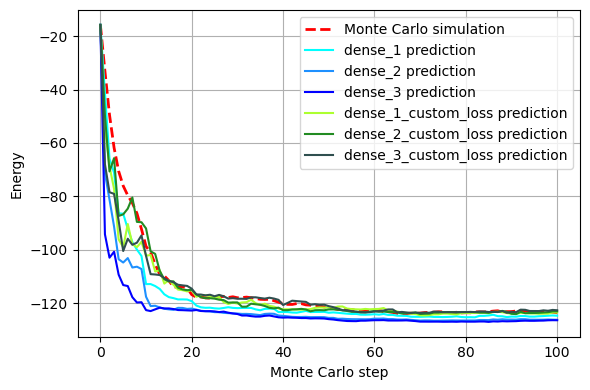

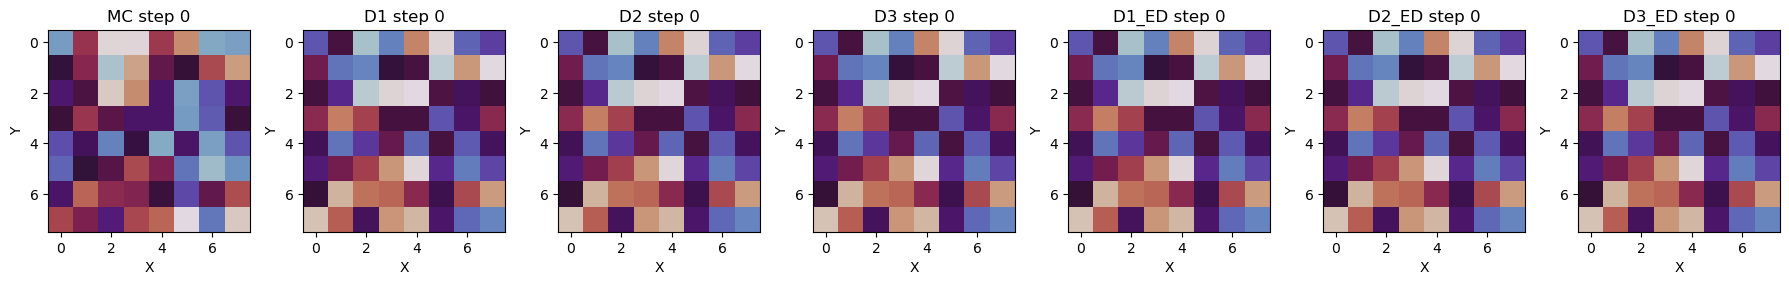

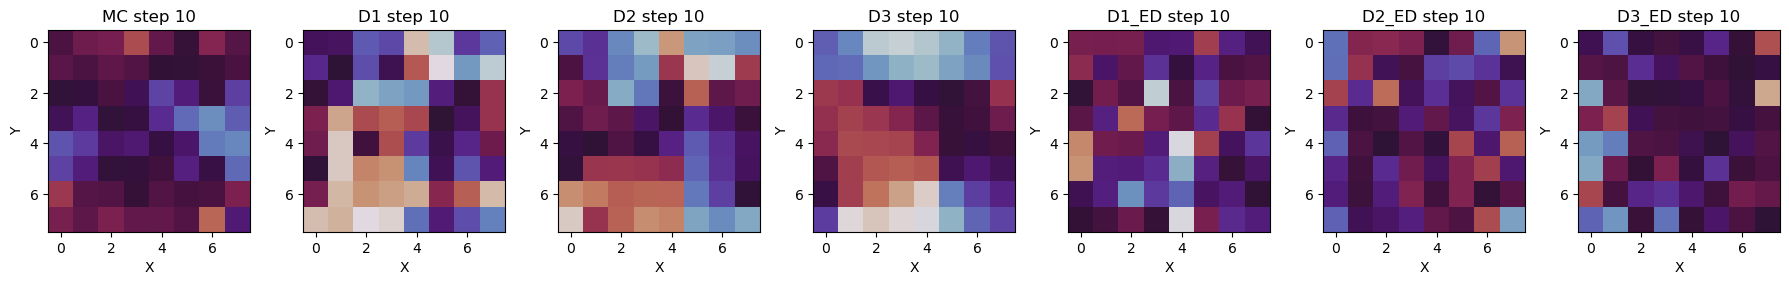

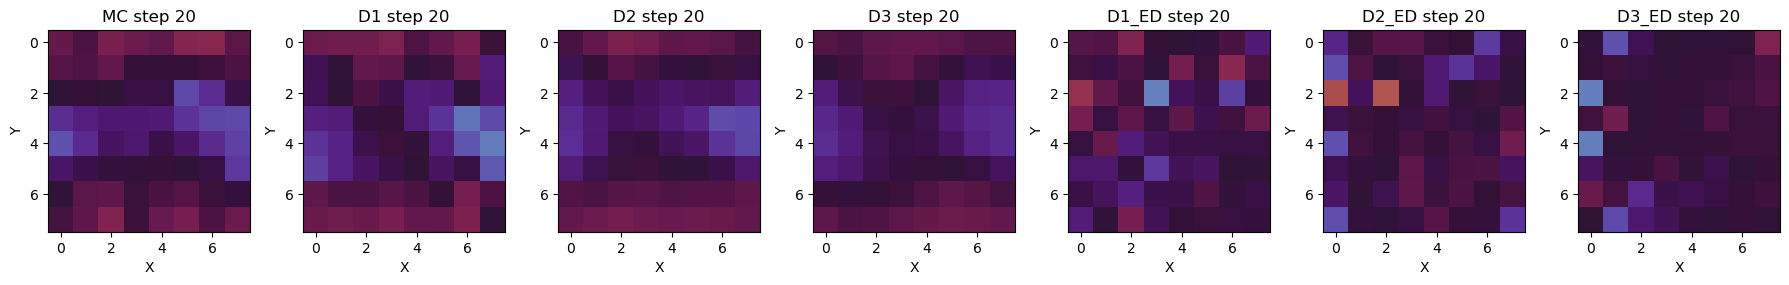

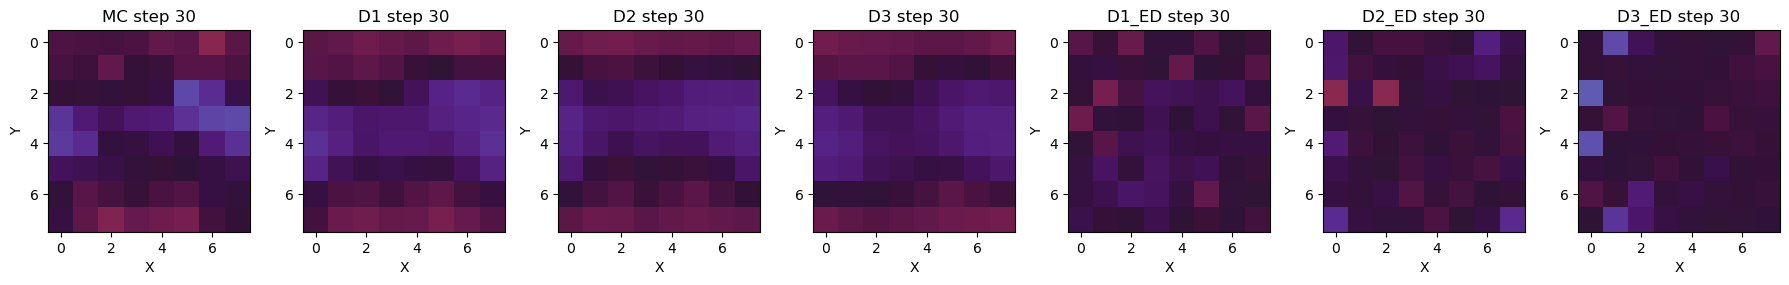

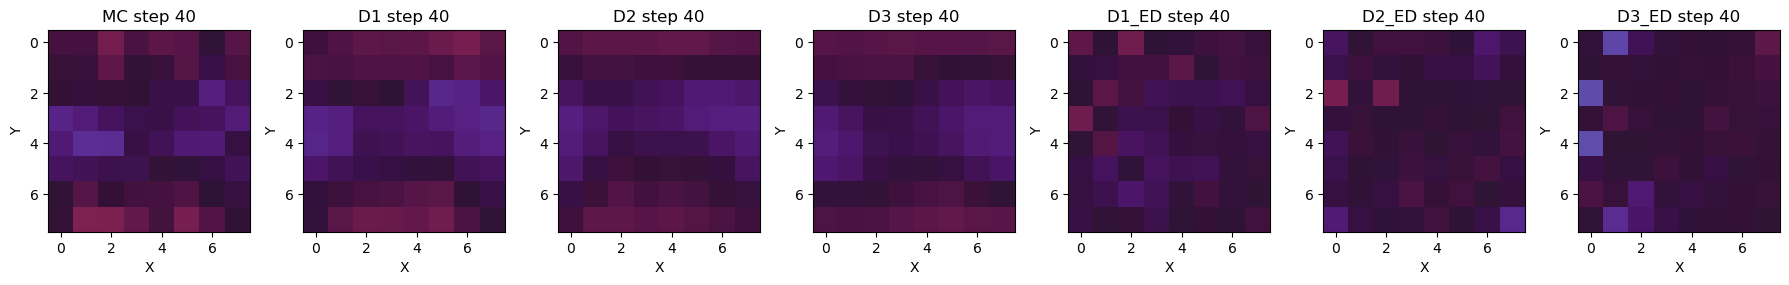

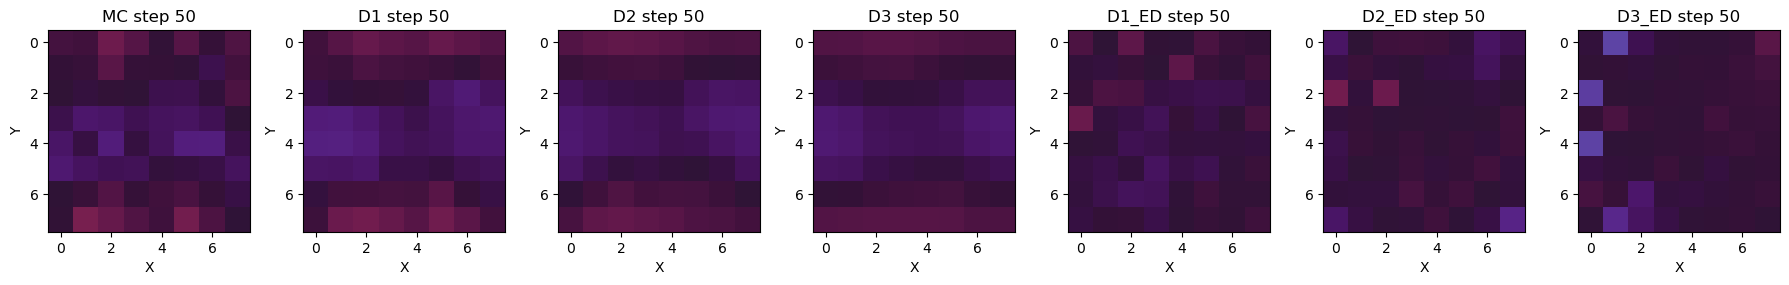

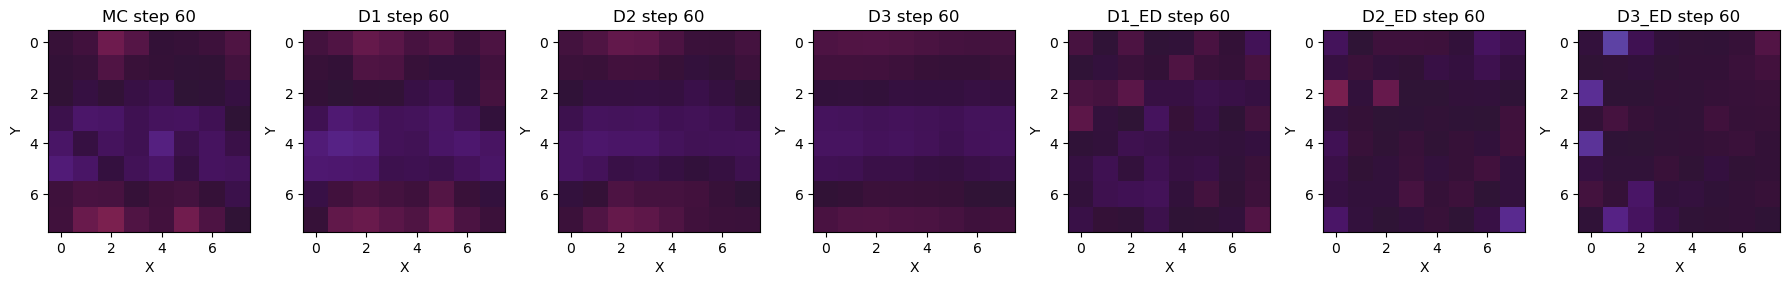

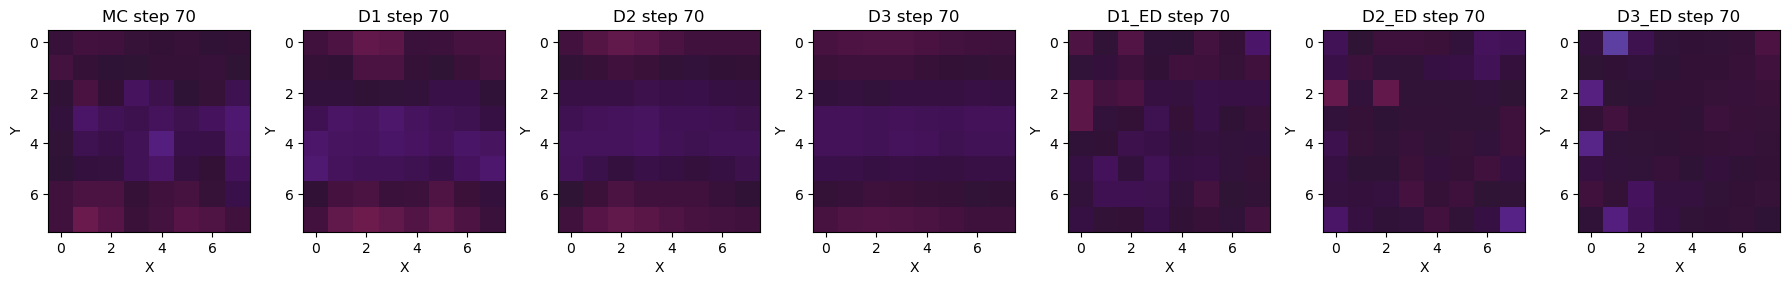

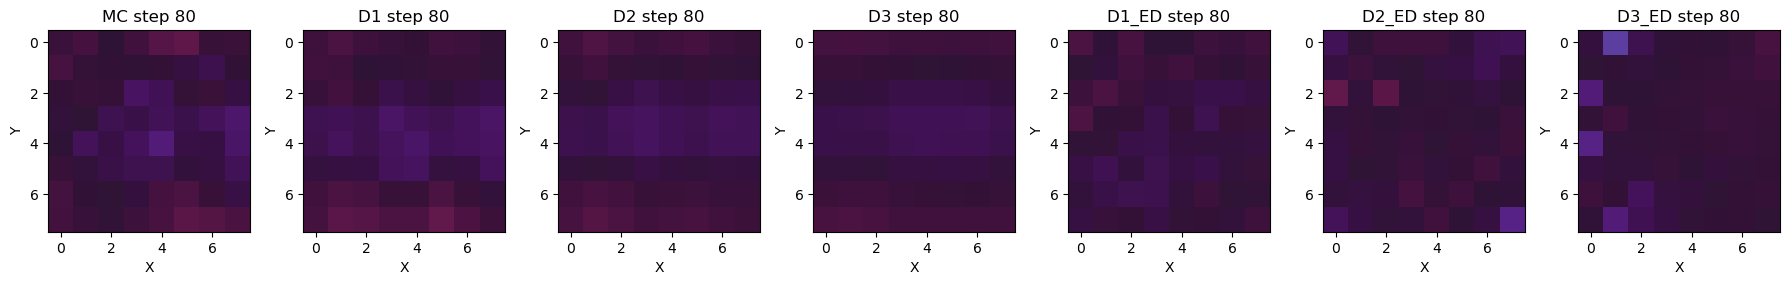

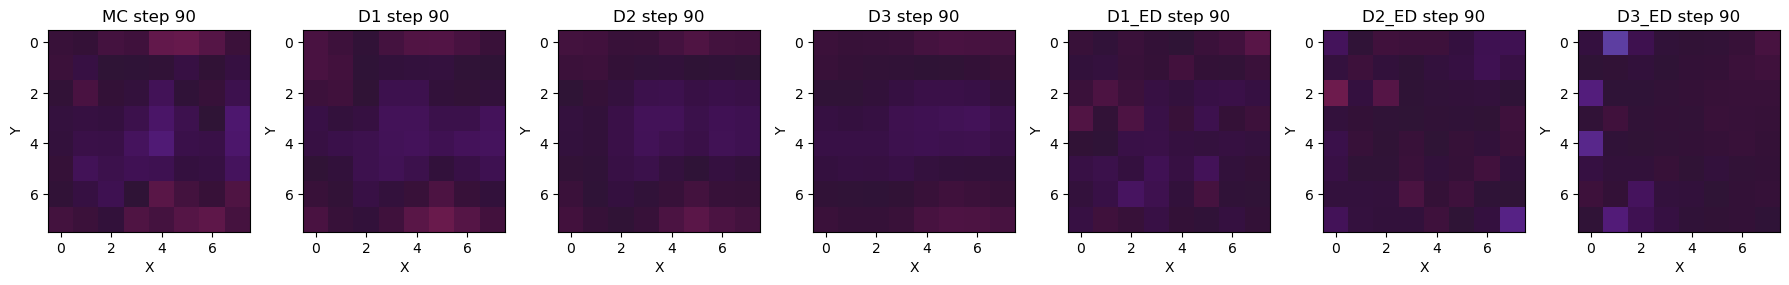

In [196]:
L = 8
J = 1.0
T = 0.1
n_steps = 100

result = run_simulation_norm_circmean(L, T, n_steps, energy=True)

In [197]:
def init_spins(L):
    return (np.random.rand(L, L) - 0.5) * 2 * np.pi

def get_local_energy(spin, neighbors, J):
    return -J * sum(np.cos(spin - neighbor) for neighbor in neighbors)

def monte_carlo_step(spins, L, T, J):
    neighbors_table = create_neighbors_table(L)
    
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)  # Select a random spin
        
        neighbors = [
            spins[neighbors_table[0][i][j]],
            spins[neighbors_table[1][i][j]],
            spins[neighbors_table[2][i][j]],
            spins[neighbors_table[3][i][j]]
        ]

        init_energy = get_local_energy(spins[i, j], neighbors, J)
    
        d_theta = np.random.uniform(-np.pi, np.pi)
        
        new_angle = spins[i, j] + d_theta
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi

        new_energy = get_local_energy(new_angle, neighbors, J)
        
        d_energy = new_energy - init_energy
        
        if d_energy < 0 or np.random.uniform(0.0, 1.0) < np.exp(-d_energy / T):
            spins[i, j] = new_angle
        
    return spins
    
def run_simulation_sep_norm_circmean(L, T, n_steps, J=1, save=False, energy=False, i=0):
    spins = init_spins(L)
    neighbors_table = create_neighbors_table(L)
    energies = []
    
    spin_configs_mc = []
    spin_configs_ae_d1 = []
    spin_configs_ae_d2 = []
    spin_configs_ae_d3 = []
    spin_configs_ae_d1_ed = []
    spin_configs_ae_d2_ed = []
    spin_configs_ae_d3_ed = []
    
    spin_configs_ae_d1.append(spins.copy())
    spin_configs_ae_d2.append(spins.copy())
    spin_configs_ae_d3.append(spins.copy())
    spin_configs_ae_d1_ed.append(spins.copy())
    spin_configs_ae_d2_ed.append(spins.copy())
    spin_configs_ae_d3_ed.append(spins.copy())   
    
    energies_d1 = []
    energies_d2 = []
    energies_d3 = []
    energies_d1_ed = []
    energies_d2_ed = []
    energies_d3_ed = []
    
    spins_d1 = spins
    spins_d2 = spins
    spins_d3 = spins
    spins_d1_ed = spins
    spins_d2_ed = spins
    spins_d3_ed = spins    

    initial_energy = calculate_lattice_energy(spins, L, J, neighbors_table)
    energies.append(initial_energy)
    
    energies_d1.append(initial_energy)
    energies_d2.append(initial_energy)
    energies_d3.append(initial_energy)
    energies_d1_ed.append(initial_energy)
    energies_d2_ed.append(initial_energy)
    energies_d3_ed.append(initial_energy)
    
    for step in range(n_steps):
        
        pred_d1 = dense_1.predict(np.array(calculate_sin_cos(spins_d1)))
        spins_d1 = calculate_angles(pred_d1, L).reshape(L, L)
        energies_d1.append(calculate_lattice_energy(spins_d1, L, J, neighbors_table))
        
        pred_d2 = dense_2.predict(np.array(calculate_sin_cos(spins_d2)))
        spins_d2 = calculate_angles(pred_d2, L).reshape(L, L)
        energies_d2.append(calculate_lattice_energy(spins_d2, L, J, neighbors_table))        
        
        pred_d3 = dense_3.predict(np.array(calculate_sin_cos(spins_d3)))
        spins_d3 = calculate_angles(pred_d3, L).reshape(L, L)
        energies_d3.append(calculate_lattice_energy(spins_d3, L, J, neighbors_table))
        
        pred_d1_ed = dense_1_ed.predict(np.array(calculate_sin_cos(spins_d1_ed)))
        spins_d1_ed = calculate_angles(pred_d1_ed, L).reshape(L, L)
        energies_d1_ed.append(calculate_lattice_energy(spins_d1_ed, L, J, neighbors_table))
        
        pred_d2_ed = dense_2_ed.predict(np.array(calculate_sin_cos(spins_d2_ed)))
        spins_d2_ed = calculate_angles(pred_d2_ed, L).reshape(L, L)
        energies_d2_ed.append(calculate_lattice_energy(spins_d2_ed, L, J, neighbors_table))        
        
        pred_d3_ed = dense_3_ed.predict(np.array(calculate_sin_cos(spins_d3_ed)))
        spins_d3_ed = calculate_angles(pred_d3_ed, L).reshape(L, L)
        energies_d3_ed.append(calculate_lattice_energy(spins_d3_ed, L, J, neighbors_table))
        
        spins = monte_carlo_step(spins, L, T, J)
        
        if energy:
            energy = calculate_lattice_energy(spins, L, J, neighbors_table)
            energies.append(energy)
        
        if save:
            path_name = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/{i}/{L}/{T}/{step}.txt"
            os.makedirs(os.path.dirname(path_name), exist_ok=True)
            np.savetxt(path_name, spins)
            
        if step % 10 == 0:
            spin_configs_mc.append(spins.copy())
            spin_configs_ae_d1.append(spins_d1.copy())
            spin_configs_ae_d2.append(spins_d2.copy())
            spin_configs_ae_d3.append(spins_d3.copy())
            spin_configs_ae_d1_ed.append(spins_d1_ed.copy())
            spin_configs_ae_d2_ed.append(spins_d2_ed.copy())
            spin_configs_ae_d3_ed.append(spins_d3_ed.copy())   
    
    autoencoder_energies = [energies_d1, energies_d2, energies_d3, energies_d1_ed, energies_d2_ed, energies_d3_ed]
    names = ["dense_1", "dense_2", "dense_3", "dense_1_custom_loss", "dense_2_custom_loss", "dense_3_custom_loss"]
    colors = ["cyan", "dodgerblue", "blue", "greenyellow", "forestgreen", "darkslategrey"]
    
    plt.figure(figsize=fig_size)
    plt.plot(energies, label="Monte Carlo simulation", linewidth=2, linestyle="--", color="red")
    for i, energy in enumerate(autoencoder_energies):
        plt.plot(energy, label=f"{names[i]} prediction", color=colors[i])
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Energy")    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{file_name}_all_sep_circnorm.png")
    plt.show()
    
    for idx in range(len(spin_configs_mc)):
        plt.figure(figsize=(18, 9))
        
        mc = (spin_configs_mc[idx] - circmean(spin_configs_mc[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 1)
        plt.imshow(mc, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'MC step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d1 = (spin_configs_ae_d1[idx] - circmean(spin_configs_ae_d1[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 2)
        plt.imshow(d1, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')

        d2 = (spin_configs_ae_d2[idx] - circmean(spin_configs_ae_d2[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 3)
        plt.imshow(d2, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')

        d3 = (spin_configs_ae_d3[idx] - circmean(spin_configs_ae_d3[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi
        
        plt.subplot(1, 7, 4)
        plt.imshow(d3, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3 step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d1_ed = (spin_configs_ae_d1_ed[idx] - circmean(spin_configs_ae_d1_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi        
        
        plt.subplot(1, 7, 5)
        plt.imshow(d1_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D1_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
       
        d2_ed = (spin_configs_ae_d2_ed[idx] - circmean(spin_configs_ae_d2_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi        
    
        plt.subplot(1, 7, 6)
        plt.imshow(d2_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D2_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        d3_ed = (spin_configs_ae_d3_ed[idx] - circmean(spin_configs_ae_d3_ed[idx], high=np.pi, low=-np.pi) + np.pi) % (2 * np.pi) - np.pi                
        
        plt.subplot(1, 7, 7)
        plt.imshow(d3_ed, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
#         plt.colorbar(label='Spin Angle')
        plt.title(f'D3_ED step {idx*10}')
        plt.xlabel('X')
        plt.ylabel('Y')        
        
        plt.tight_layout()
        plt.show()  
        
    return spins

def show_lattice(spins):
    plt.figure(figsize=(6, 6))
    plt.imshow(spins, cmap='twilight', interpolation='nearest')
    plt.colorbar(label='Spin Angle')
    plt.title(f'XY Spin Model at T={T}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

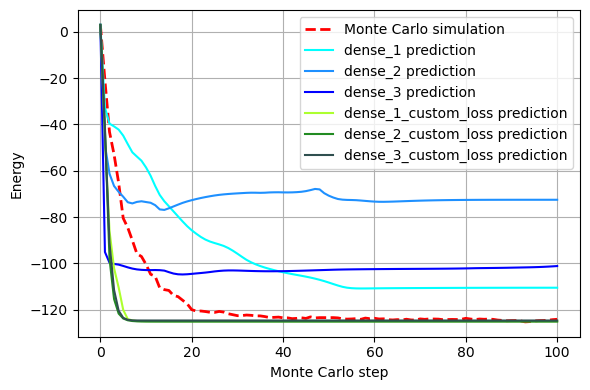

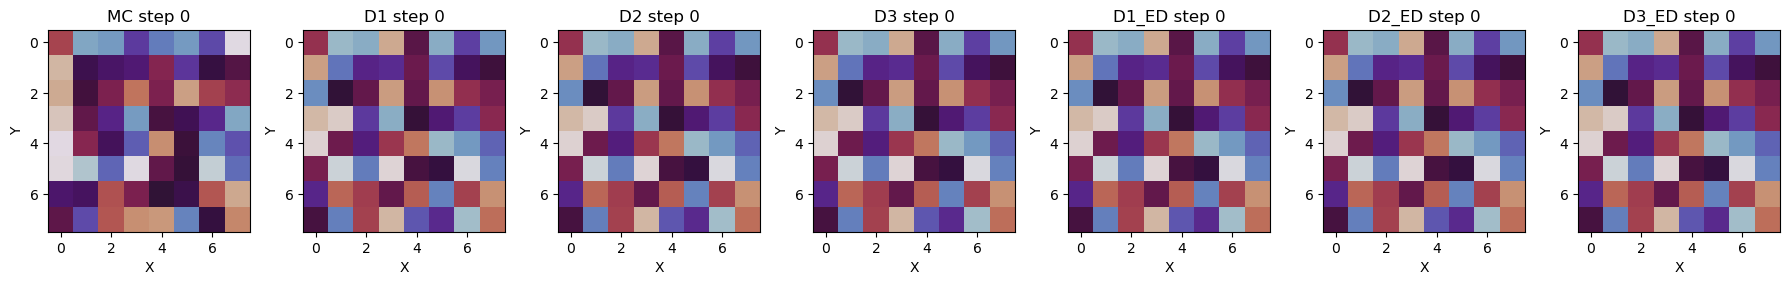

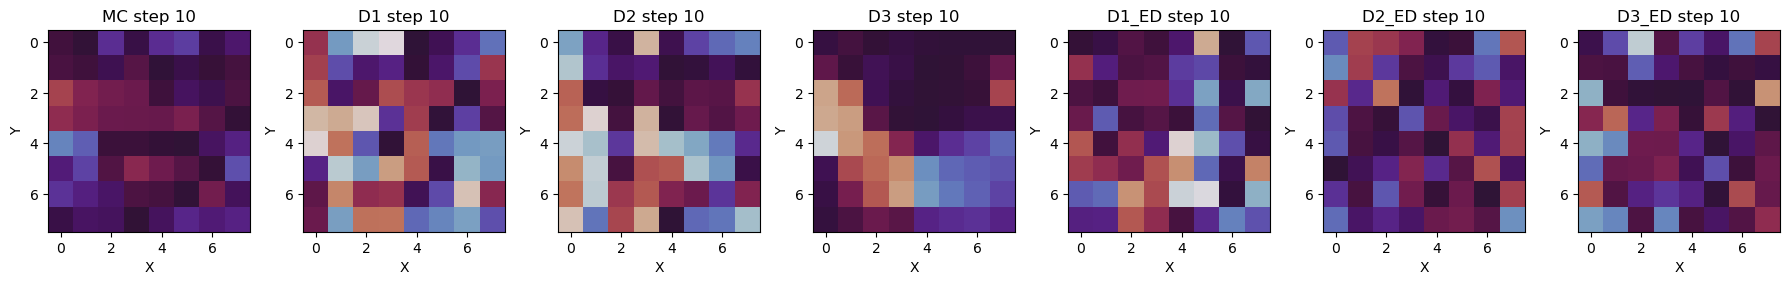

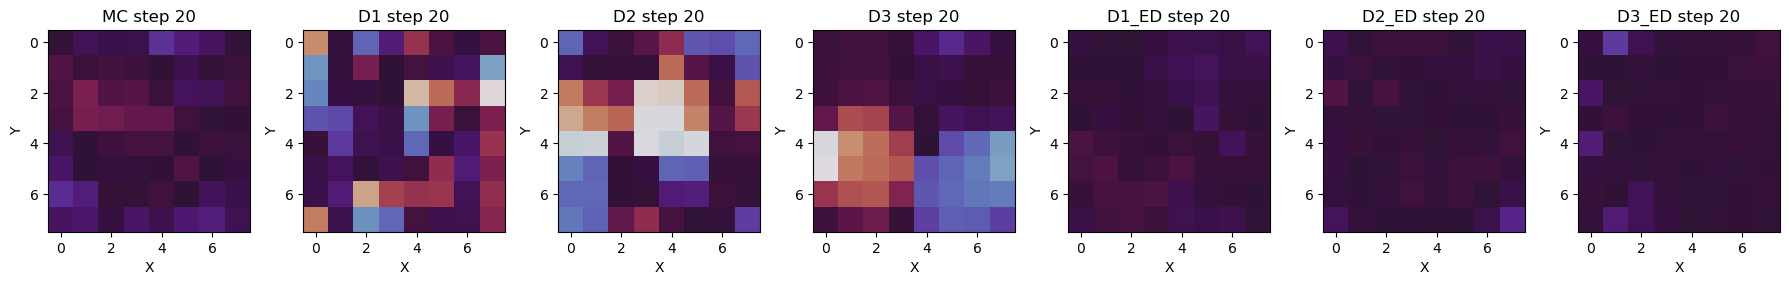

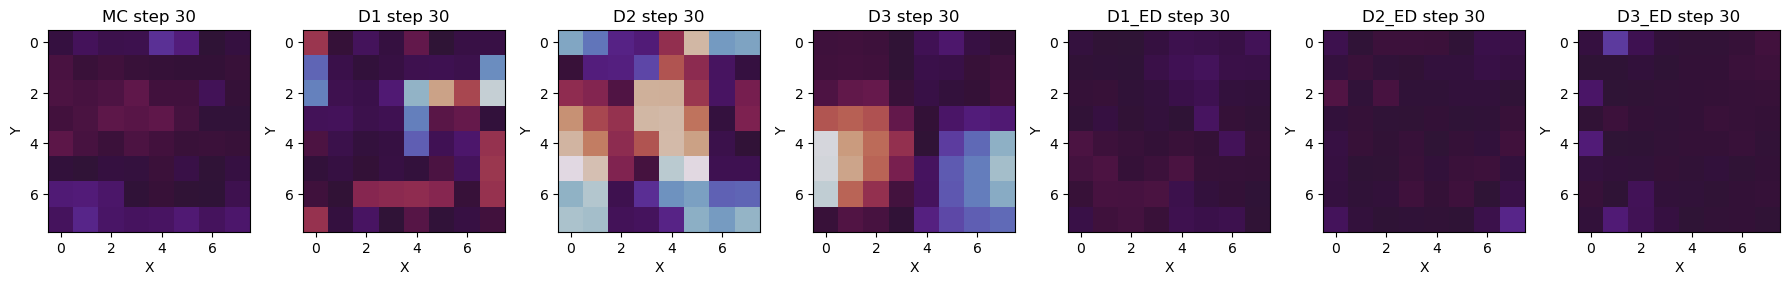

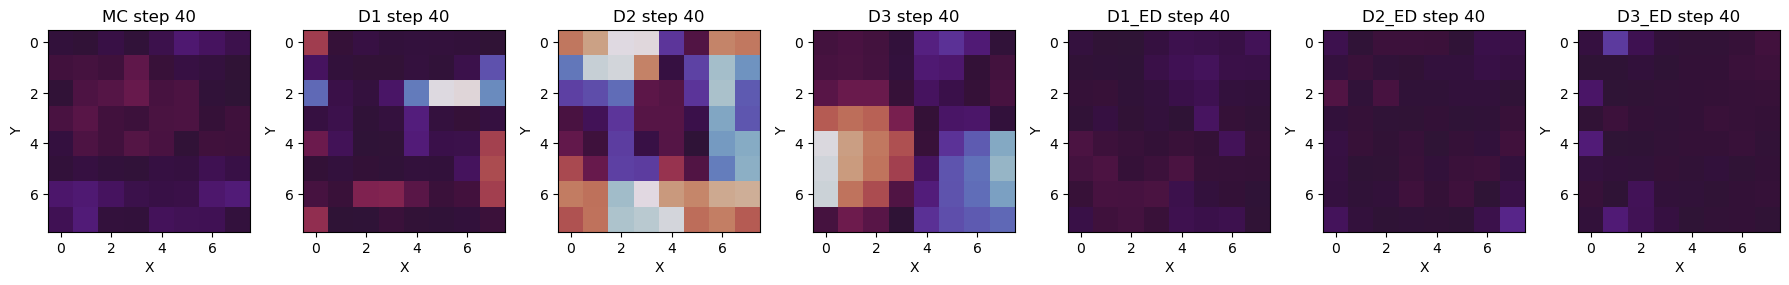

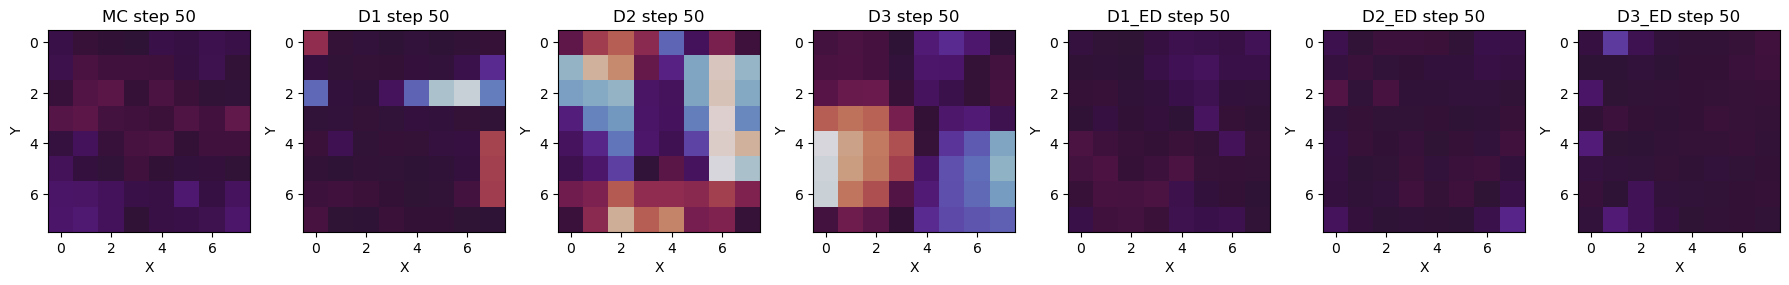

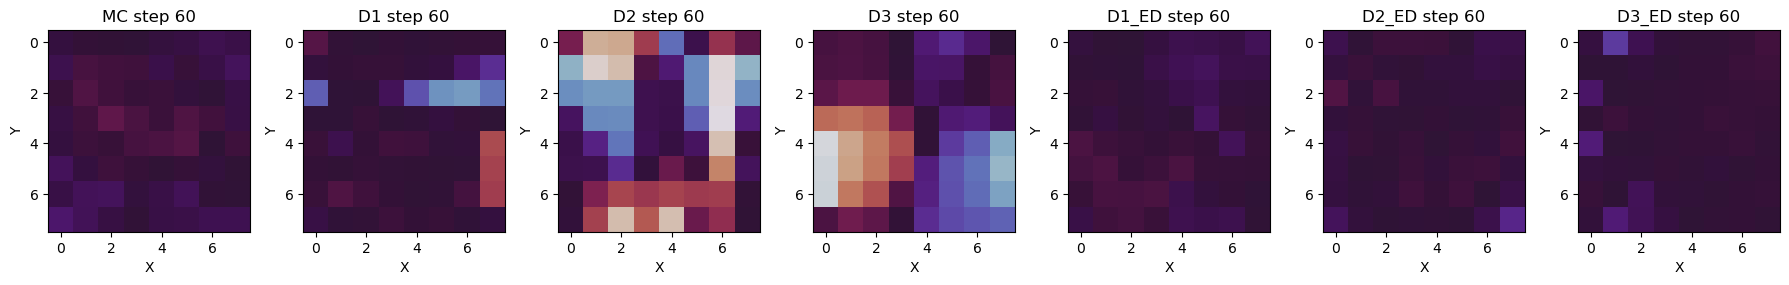

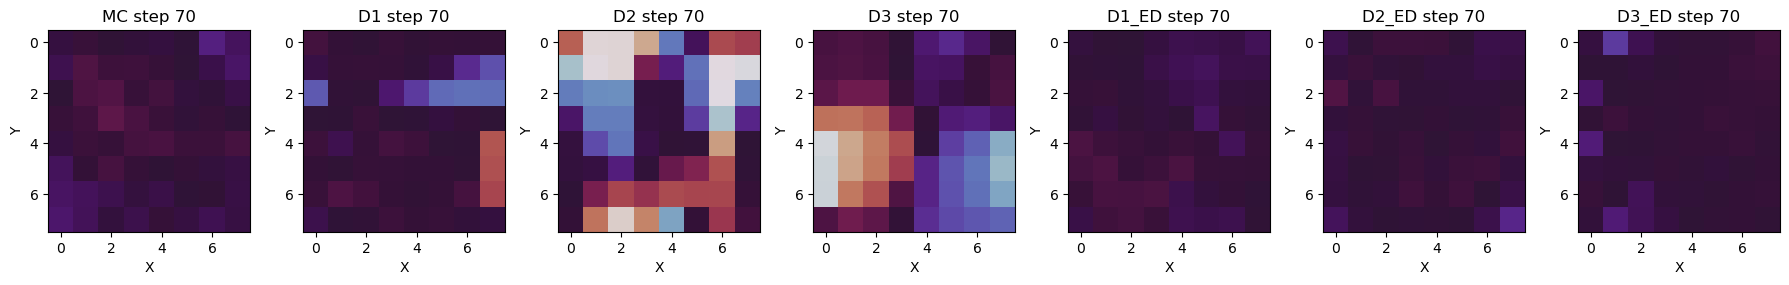

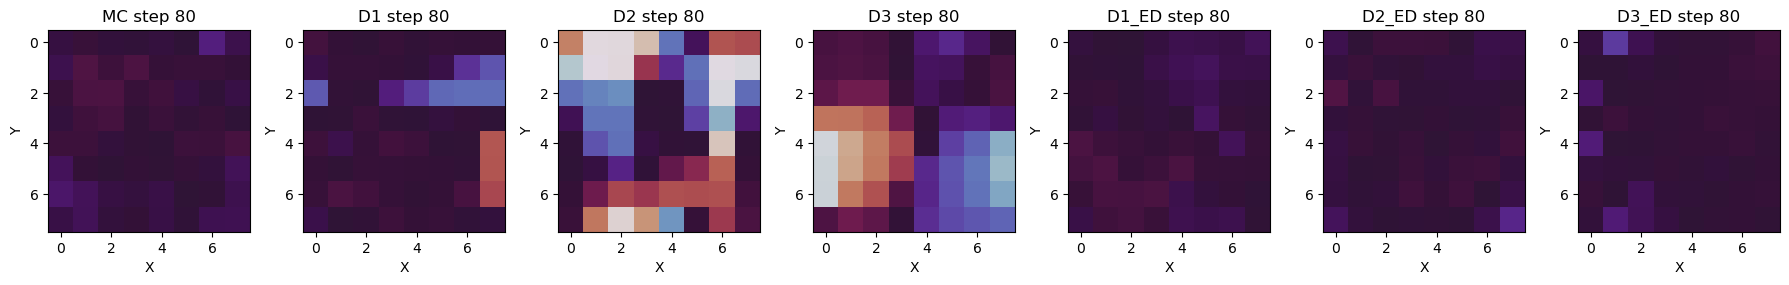

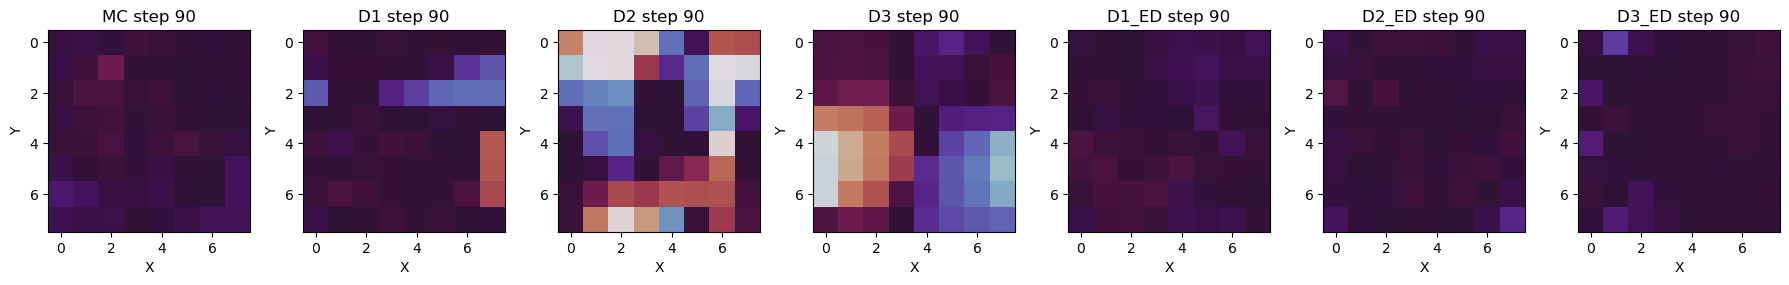

In [198]:
L = 8
J = 1.0
T = 0.1
n_steps = 100

result = run_simulation_sep_norm_circmean(L, T, n_steps, energy=True)